# NNEQ Diff EQ

Our idea here is that instead of classifying real/fake (which is difficult since the "real distribution" keeps changing) we use a NN with equality embedded inside it to parameterize the loss.

In [0]:
import torch
import torch.nn as nn
from torch import tensor, autograd
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import clear_output
import itertools

In [0]:
class Problem():
  def __init__(self, tlo=0, thi=2*np.pi, n=100, x0=0., dx_dt0=-1., mass=1., k_const=1.):
    self.tlo = tlo
    self.thi = thi
    self.n = n
    self.x0 = x0
    self.dx_dt0 = dx_dt0
    self.mass = mass
    self.k_const = k_const

In [0]:
class Generator(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, n_hidden_units=20, n_hidden_layers=2, activation=nn.Tanh(), output_tan=False):
        
        super(Generator, self).__init__()

        # input
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, n_hidden_units))
        self.layers.append(activation)
        
        # hidden
        for l in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            self.layers.append(activation)
            
        # output
        self.layers.append(nn.Linear(n_hidden_units, out_dim))
        if output_tan:
            self.layers.append(nn.Tanh())

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, n_hidden_units=20, n_hidden_layers=2, activation=nn.Tanh(), unbounded=False):
        
        super(Discriminator, self).__init__()
        
        # input
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, n_hidden_units))
        self.layers.append(activation)
        
        # hidden
        for l in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            self.layers.append(activation)
        
        # output
        self.layers.append(nn.Linear(n_hidden_units, out_dim))
        if not unbounded:
            # unbounded for WGAN (no sigmoid)
            self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

In [0]:
def diff(x, t):
  """ calculate derivative of x w.r.t. t"""
  dx_dt, = autograd.grad(x, t, grad_outputs=x.data.new(x.shape).fill_(1), create_graph=True)
  return dx_dt
 
def produce_SHO_preds(G, t, problem):
  # get initial conditions
  x0 = problem.x0
  dx_dt0 = problem.dx_dt0
  
  # get pred
  x_raw = G(t)

  # adjust for initial conditions on x and dx_dt
  x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_raw

  dx_dt = diff(x_adj, t)
  d2x_dt2 = diff(dx_dt, t)

  return x_adj, dx_dt, d2x_dt2

def produce_SHO_preds_system(G, t, problem):
  # get initial conditions
  x0 = problem.x0
  dx_dt0 = problem.dx_dt0
  
  # get pred
  x_pred = G(t)

  # x condition
  x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_pred

  # dx_dt (directly from NN output, x_pred)
  dx_dt = diff(x_pred, t)

  # u condition guarantees that dx_dt = u (first equation in system)
  u_adj = torch.exp(-t) * dx_dt0 + 2 * (1 - torch.exp(-t)) * torch.exp(-t) * x_pred + (1 - torch.exp(-t)) * dx_dt

  # compute du_dt = d2x_dt2
  du_dt = diff(u_adj, t)

  return x_adj, u_adj, du_dt

In [0]:
def true_solution(t, problem):
  # get initial conditions
  x0 = problem.x0
  dx_dt0 = problem.dx_dt0
  
  return x0*np.cos(t) + dx_dt0*np.sin(t)

def visualize_training(t, x_pred, problem):
  try:
    x_pred = x_pred.detach().cpu().numpy()
    t = t.detach().cpu().numpy()
  except:
    pass
  
  plt.scatter(t, x_pred, label='pred', alpha=1.0, s=1.0)
  plt.plot(t, true_solution(t, problem), '--', label='true', color='red')
  plt.legend()
  plt.show()

In [0]:
def train_NN(problem, n_hidden=20, n_layers=2, lr=0.001, perturb=False, cuda=True, max_iter=5e5, tol=1e-5, viz_every=100):
  # get params from problem
  tlo = problem.tlo
  thi = problem.thi
  x0 = problem.x0
  dx_dt0 = problem.dx_dt0
  n = problem.n
  mass = problem.mass
  k_const = problem.k_const
  
  
  # NN
  g = Generator(n_hidden_units=n_hidden, n_hidden_layers=n_layers)
  if cuda:
    g.cuda()
  # optimizer
  opt = torch.optim.Adam(g.parameters(), lr=lr)

  # input grid
  t = torch.linspace(tlo, thi, n, dtype=torch.float, requires_grad=True).reshape(-1,1)
  if cuda:
    t = t.cuda()

  # inter-point spacing
  delta_t = t[1]-t[0]
  if cuda:
    delta_t = delta_t.cuda()

  # batch getter
  def get_batch():
    """ perturb grid """
    if perturb:
      return t + delta_t * torch.randn_like(t) / 3
    else:
      return t
    
  # training loop
  i = 0
  loss = 1e6
  
  while loss > tol and i < max_iter:
    i += 1
    
    opt.zero_grad()
    
    t = get_batch()
    x_adj, dx_dt, d2x_dt2 = produce_SHO_preds(g, t, problem)
    
    lhs = x_adj
    rhs = -(mass/k_const) * d2x_dt2
    
    loss = torch.mean((lhs-rhs)**2)
    loss.backward(retain_graph=True)
    opt.step()
    
    if i % viz_every == 0:
      clear_output(True)
      print('Iter = {}'.format(i))
      print('Loss = {}'.format(loss))
      visualize_training(t, x_adj, problem)
                
    


In [0]:
torch.cuda.is_available()

True

In [0]:
eqn = Problem()

Iter = 1100
Loss = 2.0998524632886983e-05


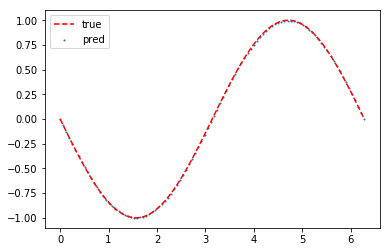

In [0]:
train_NN(eqn, perturb=False)